In [2]:
from pathlib import Path

import geopandas as gdp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import STL 
from statsmodels.tsa.seasonal import seasonal_decompose

from load_data import load_data

register_matplotlib_converters()

plt.rc('figure',figsize=(16,12))

## Variables

Variables available:

    - air temp
    - ice concentration
    - ice thickness
    - salinity
    - ocean temp
    
    
Data for ocean is only available from 2019 to roughly present.

In [127]:
def load_data_local(fname, var):
    with xr.open_dataset(fname) as ds:
        df = ds.to_dataframe()

    # Remove non-monotonic time-stamps
    # - find time diff > 2 days
    # - max in original dataset without problems of 2 days (leap year)
    ns_per_day = 86400000000000
    ndays = 2
    limit = ndays * ns_per_day
    if np.max(np.diff(df.index.values)) > limit:
        tmp_df = df.copy()
        while np.max(np.diff(tmp_df.index.values)) > limit:
            #print(np.max(np.diff(tmp_df.index.values)), np.argmax(np.diff(tmp_df.index.values)))
            drop_ix = np.argmax(np.diff(tmp_df.index.values)) + 1
            drop_time = tmp_df.iloc[drop_ix, :]
            new_df = tmp_df.drop(index=[drop_time.name])
            tmp_df = new_df
        df = tmp_df
    
    new_times = pd.date_range(start=df.index[0], end=df.index[-1], freq='D')
    new_df = df.reindex(index=new_times, columns=[var])
    new_df.fillna(method='ffill', inplace=True)
    
    return new_df

In [128]:
pabrc = load_data_local('station-data/PABRC-ice_conc.nc', 'ICE_C_GDS0_SFC_ave6h')

<Day>

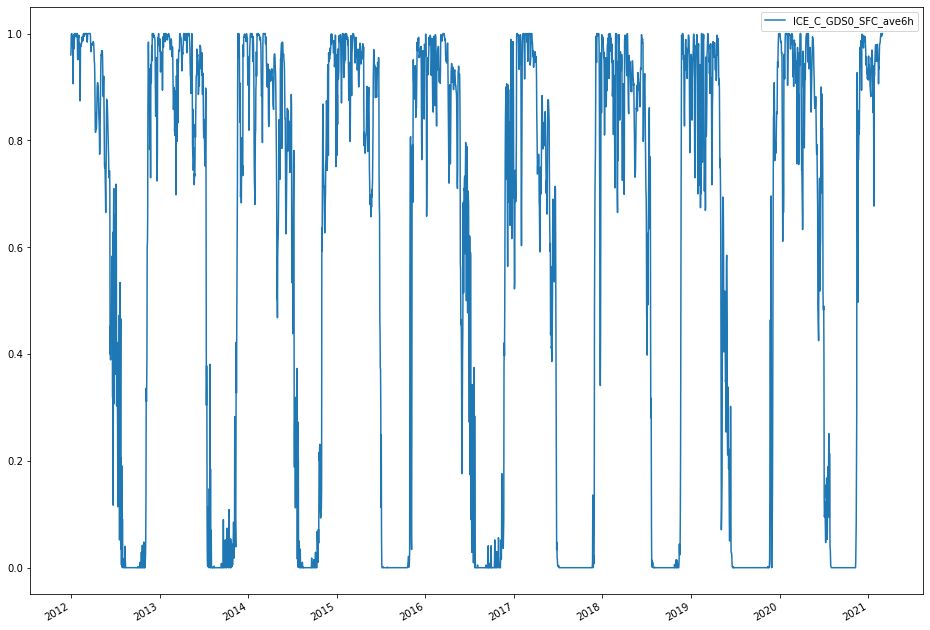

In [129]:
pabrc.plot()
pabrc.index.freq

In [130]:
pabrc

,ICE_C_GDS0_SFC_ave6h
2012-01-01 06:00:00,0.960
2012-01-02 06:00:00,0.965
2012-01-03 06:00:00,0.998
2012-01-04 06:00:00,0.999
2012-01-05 06:00:00,1.000
...,...
2021-02-24 06:00:00,0.996
2021-02-25 06:00:00,0.995
2021-02-26 06:00:00,1.000
2021-02-27 06:00:00,1.000


## Try seasonal trend decomposition

In [131]:
from statsmodels.tsa.seasonal import STL

seasonal=365, period=365, trend=547, low_pass=367


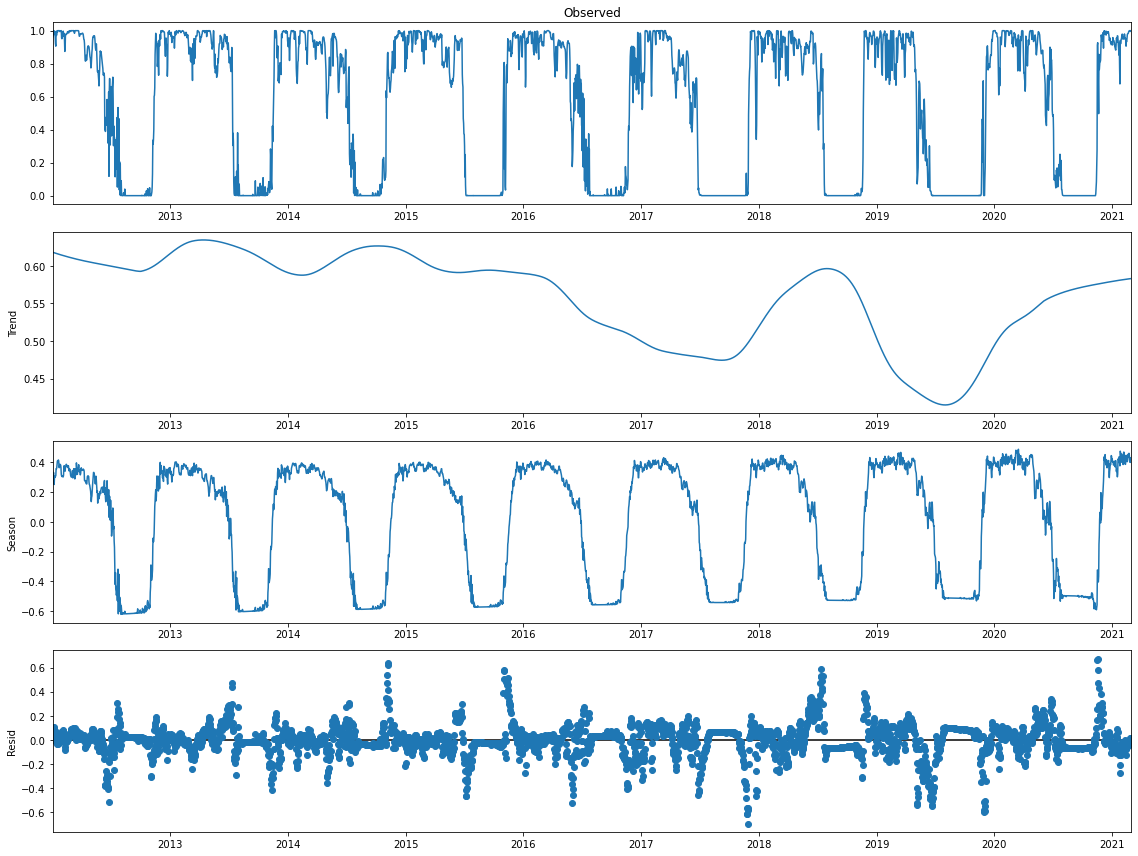

In [157]:
# seasonal - length of seasonal smoother
# - monthly? seasonally (90 days)?  annually?
seasonal = 365
period = 365

trend = int(seasonal * 1.5)
if trend % 2 == 0:
    trend += 1

# from doc, usually the smallest odd number > period
if period % 2 == 0:
    low_pass = period + 1
else:
    low_pass = period + 2
    
print(f'seasonal={seasonal}, period={period}, trend={trend}, low_pass={low_pass}')
    
stl = STL(pabrc, period=period, seasonal=seasonal, trend=trend)
res = stl.fit()
fig = res.plot()

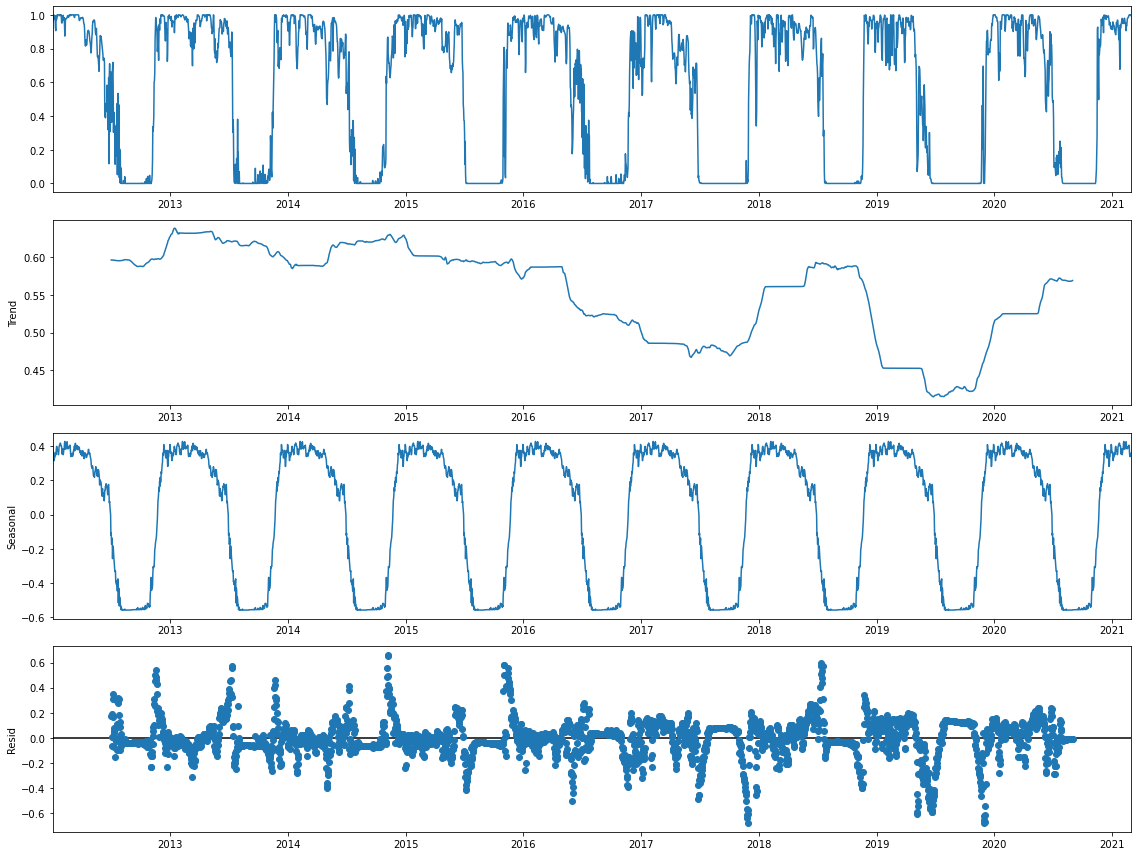

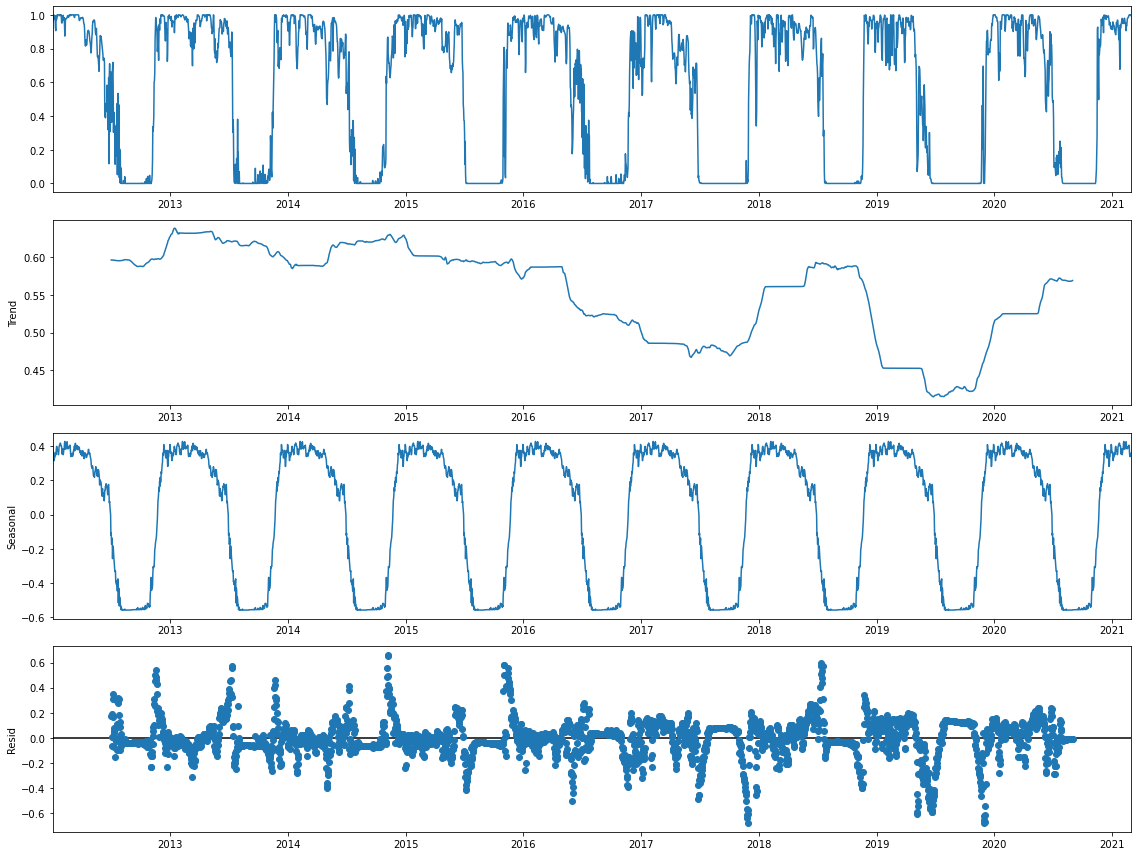

In [134]:
decomposed = seasonal_decompose(pabrc, model='additive', period=365)
decomposed.plot()

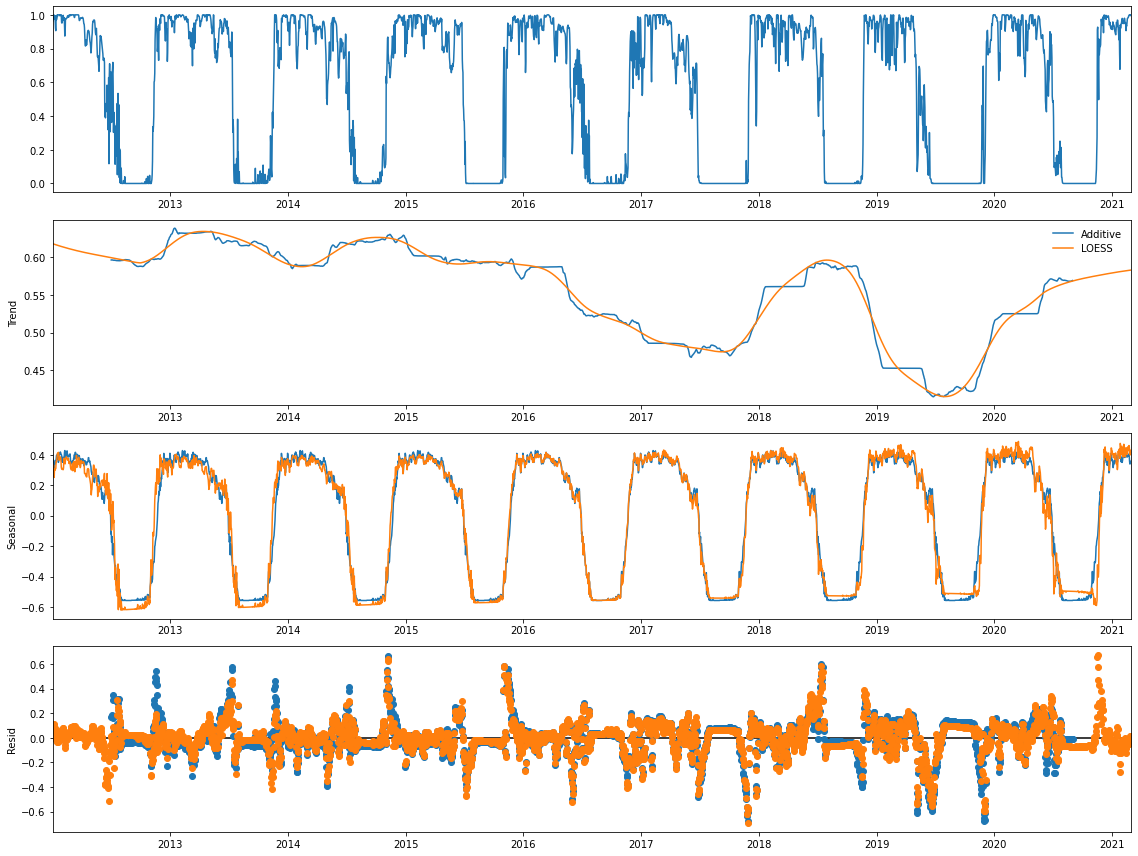

In [135]:
def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ['trend', 'seasonal', 'resid']
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == 'resid':
            ax.plot(series, marker='o', linestyle='none')
        else:
            ax.plot(series)
            if comp == 'trend':
                ax.legend(legend, frameon=False)
                
fig = decomposed.plot()
add_stl_plot(fig, res, ['Additive', 'LOESS'])

In [136]:
# Try forecast

In [137]:
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

                    STL Decomposition and SARIMAX Results                     
Dep. Variable:                      y   No. Observations:                 3347
Model:                 ARIMA(1, 1, 0)   Log Likelihood                4557.738
Date:                Wed, 28 Apr 2021   AIC                          -9109.477
Time:                        22:46:25   BIC                          -9091.130
Sample:                    01-01-2012   HQIC                         -9102.914
                         - 02-28-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -9.359e-06      0.001     -0.009      0.993      -0.002       0.002
ar.L1         -0.0720      0.008     -8.556      0.000      -0.089      -0.056
sigma2         0.0038   3.65e-05    105.165      0.0

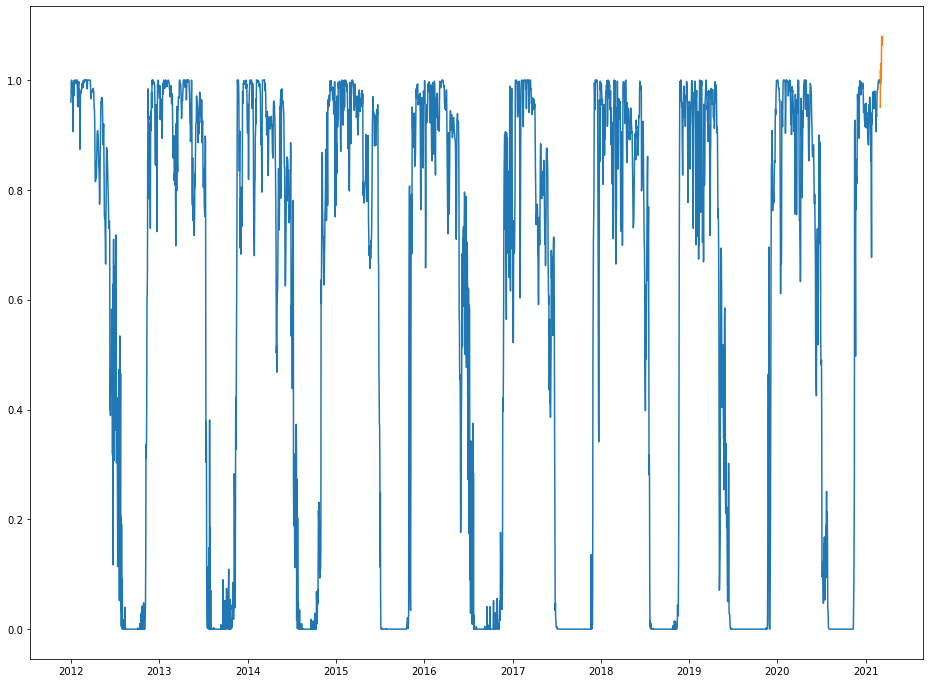

In [154]:
stl_forecast = STLForecast(
    pabrc, 
    ARIMA, 
    period=period, 
    seasonal=seasonal,
    trend=trend,
    model_kwargs=dict(order=(1,1,0), trend='t')
)
stl_forecast_res = stl_forecast.fit()
forecast = stl_forecast_res.forecast(10)
plt.plot(pabrc)
plt.plot(forecast)
print(stl_forecast_res.summary())

In [152]:
stl_forecast = STLForecast(
    pabrc, 
    ARIMA, 
    model_kwargs=dict(order=(1,1,0), trend='t')
)
stl_forecast_res = stl_forecast.fit()
forecast = stl_forecast_res.forecast(365)
print(stl_forecast_res.summary())

                    STL Decomposition and SARIMAX Results                     
Dep. Variable:                      y   No. Observations:                 3347
Model:                 ARIMA(1, 1, 0)   Log Likelihood                4768.651
Date:                Wed, 28 Apr 2021   AIC                          -9531.303
Time:                        22:45:59   BIC                          -9512.956
Sample:                    01-01-2012   HQIC                         -9524.740
                         - 02-28-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          7.809e-06      0.001      0.008      0.994      -0.002       0.002
ar.L1         -0.0045      0.008     -0.555      0.579      -0.020       0.011
sigma2         0.0034   3.09e-05    109.543      0.0

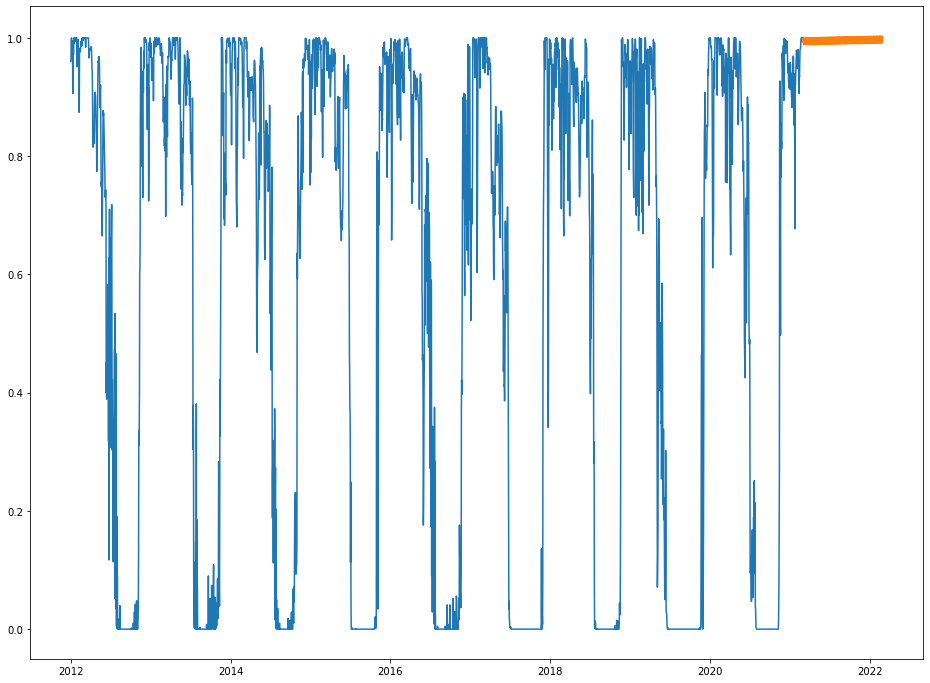

In [153]:
plt.plot(pabrc)
plt.plot(forecast)

## Tests for stationarity

It looks like the time series is shifting as one would expect when freezing and thawing times migrating.
So we test the time series for stationarity.


In [159]:
from statsmodels.tsa.stattools import adfuller, kpss

# Dickey-Fuller Test

- Null hypothesis: The series has a unit root (Non-stationary).
- Alternate hypothesis: The series has no unit root (Stationary).
    
If the null hypothesis fails to be rejected, there may be evidence that the series is non-stationary.

The ADF statistic is a negative number.  The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some confidence level. [Wikipedia](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test)

The critical values are calculated given the number of samples for the 99%, 95%, and 90% confidence levels.

In [177]:
# why is this not just built into the library?
# taken from stationarity example notebook:
# https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [178]:
# The test statistic of -4.67 is greater than the 99% level of -3.43.
# So, we reject the null hypthothesis that the series has a unit root and it is stationary.
adf_test(pabrc)

Results of Dickey-Fuller Test:
Test Statistic                   -4.678636
p-value                           0.000092
#Lags Used                       29.000000
Number of Observations Used    3317.000000
Critical Value (1%)              -3.432323
Critical Value (5%)              -2.862412
Critical Value (10%)             -2.567234
dtype: float64


## KPSS Test

- Null hypothesis: The series does not have a unit root (stationary)
- Alternatve hypothesis: The series has a unit root (non-stationary)

So, this test is like the opposite of the others.

In [182]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [184]:
# Test statistic of 0.175 is less than any of the critical values, so we
# fail to reject the null hypothesis -> stationary
kpss_test(pabrc)

Results of KPSS Test:
Test Statistic            0.174827
p-value                   0.100000
#Lags Used               37.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/env/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


### Try with data resampled to week

In [189]:
weekly = pabrc.resample('W').mean()

<AxesSubplot:>

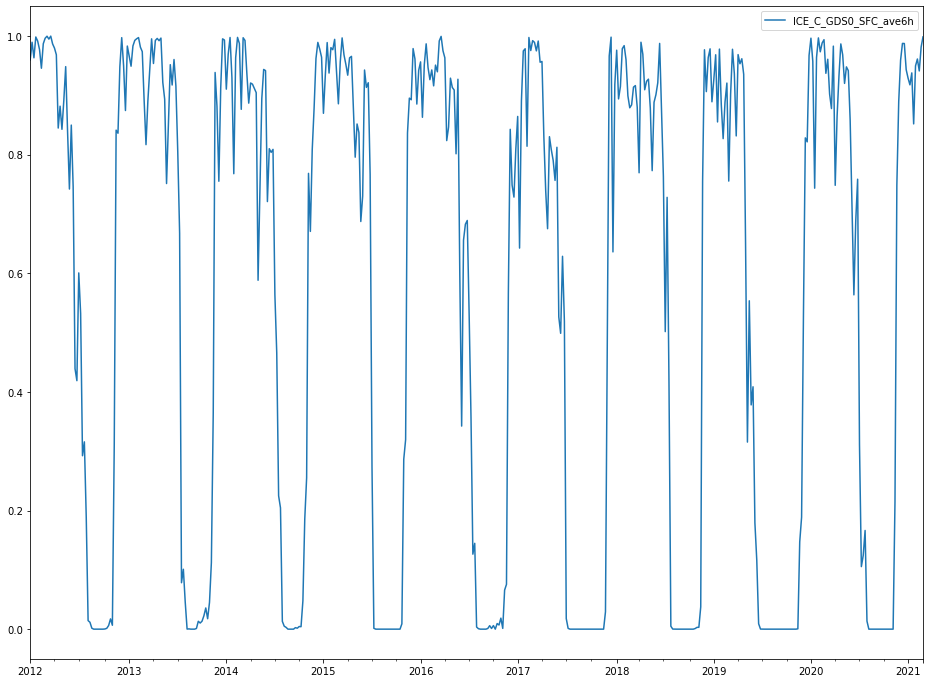

In [191]:
weekly.plot()

                    STL Decomposition and SARIMAX Results                     
Dep. Variable:                      y   No. Observations:                  479
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 409.442
Date:                Thu, 29 Apr 2021   AIC                           -812.883
Time:                        19:39:57   BIC                           -800.375
Sample:                    01-01-2012   HQIC                          -807.966
                         - 02-28-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -6.284e-05      0.004     -0.015      0.988      -0.009       0.008
ar.L1         -0.0992      0.032     -3.098      0.002      -0.162      -0.036
sigma2         0.0106      0.000     24.116      0.0

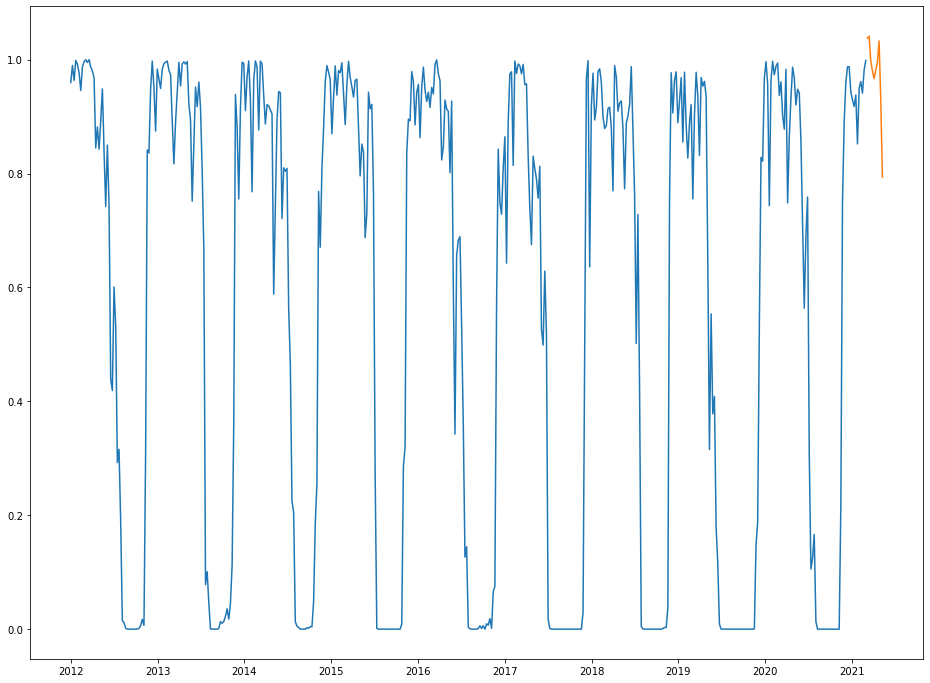

In [198]:
# seasonal - length of seasonal smoother
# - monthly? seasonally (90 days)?  annually?
seasonal = 53
period = 52

trend = int(seasonal * 1.5)
if trend % 2 == 0:
    trend += 1

# from doc, usually the smallest odd number > period
if period % 2 == 0:
    low_pass = period + 1
else:
    low_pass = period + 2


stl_forecast = STLForecast(
    weekly, 
    ARIMA, 
    period=period, 
    seasonal=seasonal,
    trend=trend,
    model_kwargs=dict(order=(1,1,0), trend='t')
)
stl_forecast_res = stl_forecast.fit()
forecast = stl_forecast_res.forecast(10)
plt.plot(weekly)
plt.plot(forecast)
print(stl_forecast_res.summary())

37